# Structured Bayesian Optimisation with Pyro

Goal: apply Structured Bayesian Optimisation (SBO) strategy to minimize Branin-Hoo function with pyro.

Based on: 
- Semiparametric-Model-BraninHoo.ipynb
- branin_hoo_pyro_sbo.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


### Setting random seed

In [3]:
seed_number = 555

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_random_seed(seed_number)

# Objective function

In [4]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Initial (train) data

Generating random training points

In [5]:
N_points = 1
X = torch.rand(N_points, 2)*15 + torch.FloatTensor([-5, 0])
y = branin_hoo(X)

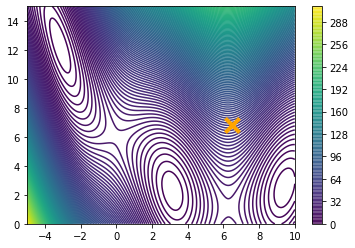

In [6]:
def plot_target():

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    Z_mesh = branin_hoo(torch.stack((X1_mesh, X2_mesh), dim=2))

    plt.contour(X1_mesh, X2_mesh, Z_mesh, strides)
    plt.colorbar()
    
plot_target()
plt.scatter(X[:,0].detach().numpy(), X[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);

# Parametric model in pyro

Matching the parametric function used in BOAT

In [7]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + \
            torch.pow(x2, 2) + self.gamma

# Semi parametric model as implemented by Brooks

In [8]:
class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
        self.parametric_mean = parametric_mean
        self.X = X
        self.y = y
        
        # Define GP (to be used for residual)
        self.kernel = gp.kernels.Matern52(input_dim=X.shape[1], lengthscale=100*torch.ones(X.shape[1]))
        self.gp = gp.models.GPRegression(X, y, self.kernel) 
        self.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([2]).to_event())
        self.gp.kernel.variance = PyroSample(dist.Uniform(0, 200))
        self.gp.noise = PyroSample(dist.Uniform(0, 1))

    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        # sample mu, sigma
        mu, sigma = self.gp(X)
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat, sigma

# The minimalistic SBO Algorithm

### Acquisition function

In [9]:
def lower_confidence_bound(sbo_model, x, kappa=2):
    """ Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$ """
    
    mu, variance = sbo_model(x)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(sbo_model, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = sbo_model.y.min()
    mu, variance = sbo_model(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(sbo_model, x, af='EI'):
    """ Defines acquisition function. """

    if af == "EI":
        return expected_improvement(sbo_model, x)
    elif af == "LCB":
        return lower_confidence_bound(sbo_model, x)
    else:
        return None

### Model training

In [10]:
def train(sbo_model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
    
    # TODO: check if param store needs to be cleared here.
    pyro.clear_param_store()
    # setup the inference algorithm
    guide = autoguide.AutoMultivariateNormal(sbo_model.model)
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(sbo_model.model, guide, optimizer, loss)
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

### Finding new candidates on the acquisition function landscape

In [11]:
def find_a_candidate(sbo_model, x_init, constr, num_steps=1000):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser 
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    minimizer = optim.Adam([x_uncon])
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        y = acquisition_func(sbo_model, x)
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(num_steps):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [12]:
def next_x(sbo_model, constr, num_candidates=5):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with last step
    x_init = sbo_model.X[-1:]
    for i in range(num_candidates):

        x = find_a_candidate(sbo_model, x_init, constr)
        y = acquisition_func(sbo_model, x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

### Updating posterior

In [13]:
def update_posterior(sbo_model, x_new, num_steps=1000):
    
    # evaluate f at new point
    bh_y = branin_hoo(x_new) 
        
    # incorporate new evaluation
    sbo_model.X = torch.cat([sbo_model.X, x_new]) 
    sbo_model.y = torch.cat([sbo_model.y, bh_y])
    
    losses, guide = train(sbo_model, num_steps=num_steps)
    return guide

### Visualising SBO model

In [14]:
def plot_function(f, n_points=100):
    XX, YY = np.meshgrid(np.linspace(-5, 10, n_points), np.linspace(0, 15, n_points))
    ZZ = f(torch.FloatTensor(np.stack([XX.ravel(), YY.ravel()]).T))
    plt.imshow(ZZ.reshape(n_points, n_points));
    plt.xticks(np.linspace(0, n_points, 6), np.linspace(-5, 10, 6))
    plt.yticks(np.linspace(0, n_points, 6), np.linspace(0, 15, 6))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.set_cmap('jet')
    plt.colorbar()
    plt.gca().invert_yaxis()

def viz_sbo_model(sbo_model, sbo_model_guide):
    predictive = pyro.infer.Predictive(sbo_model, guide=sbo_model_guide, num_samples=100, return_sites=('y',))
    plt.figure(figsize=(6,4))
    with torch.no_grad():
        plot_function(lambda X: predictive(X)['y'].mean(0))

# Main routine

In [15]:
pyro.clear_param_store()
# initial training of the model
semiparametric = SemiParametricModel(X, y, ParametricMeanFn())
_, semiparametric_guide = train(semiparametric, num_steps=8000)

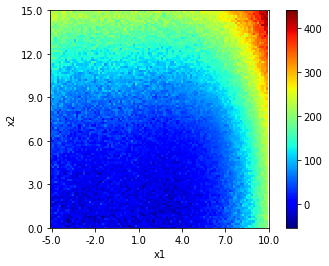

In [16]:
viz_sbo_model(semiparametric, semiparametric_guide)

In [17]:
sbo_steps = 3

for i in range(sbo_steps):
    xmin = next_x(semiparametric, constr)
    print("SBO step: ", i+1, "new point: ", xmin)
    semiparametric_guide = update_posterior(semiparametric, xmin, num_steps=8000)

SBO step:  1 new point:  tensor([[4.0348, 3.1425]])
SBO step:  2 new point:  tensor([[3.1810, 7.1994]])
SBO step:  3 new point:  tensor([[2.1574, 0.7549]])


## Final y_hat landscape

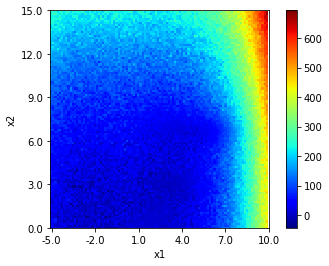

In [18]:
viz_sbo_model(semiparametric, semiparametric_guide)

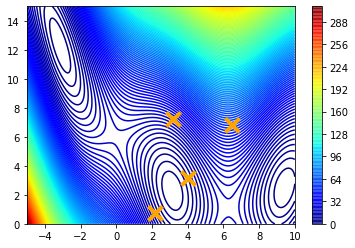

In [19]:
plot_target()
plt.scatter(semiparametric.X[:,0].detach().numpy(), semiparametric.X[:,1].detach().numpy(), marker="x", s=200, c='orange', zorder=2, linewidth=4);